In [1]:
# 거리 기반으로 반경 1km내 음식점 필터링
from math import sin, cos, sqrt, atan2, radians
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import random
import pickle
from tqdm import tqdm
import time
import datetime
import os
import matplotlib.pyplot as plt
import json
import seaborn as sns; sns.set_theme(color_codes=True)
# from models.model import CossimRecommender

In [2]:
# 예제
data_dir = '/opt/ml/final-project-level3-recsys-02/data/'
with open(data_dir+"/food.pickle", "rb")  as f:
    place = pickle.load(f)
            
place['placeID'] = place.apply(lambda x : x['placeName'] + x['placeAddress'], axis = 1)
place['placeID'] = place['placeID'].apply(lambda x : x.replace(" ", ""))
place['map'] = place[['longitude','latitude']].apply(lambda x: tuple(x.values),axis=1)
place = place[~place.placeType.str.contains('성급')].reset_index().copy()

In [3]:
def time_convert(x):
    return time.mktime(datetime.datetime.strptime('2022.'+x[:-1], "%Y.%m.%d.").timetuple())

In [4]:
review_path = os.path.join(data_dir, 'reviewInfo.json')
with open(review_path, 'r') as f:
    review_dict = json.load(f)
review_df = pd.DataFrame.from_dict(review_dict)
review_df.drop(['_id', 'reviewUserID', 'reviewContent', 'reviewInfoScore','reviewInfoVisitCount'], axis=1,inplace=True)

review_df['placeID'] = review_df.apply(lambda x : x['placeName'] + x['placeAddress'], axis = 1)
review_df['placeID'] = review_df['placeID'].apply(lambda x : x.replace(" ", ""))
review_df['timestamp'] = review_df.reviewInfoVisitDay.apply(time_convert)
col_list = ['userHash', 'placeID', 'timestamp']
review_df = review_df[col_list]

csv_path = os.path.join(data_dir, 'review.csv')
review_df.to_csv(csv_path, index=False)

In [5]:
review_path = os.path.join(data_dir, 'review.csv')
review_df = pd.read_csv(review_path)
review = review_df[review_df.placeID.isin(place.placeID.unique())].reset_index(drop=True)
review

,userHash,placeID,timestamp
0,5e7219bb8f87a842bc608e26,밀밭정원서울마포구마포대로16길13,1.652314e+09
1,5c27ac4f31fda71be490e8b7,밀밭정원서울마포구마포대로16길13,1.651709e+09
2,61b106a74b246250298287f6,밀밭정원서울마포구마포대로16길13,1.651104e+09
3,62221e887bac195eed62a637,밀밭정원서울마포구마포대로16길13,1.651104e+09
4,5eeb1daf8f87a842bc1e61cb,밀밭정원서울마포구마포대로16길13,1.651104e+09
...,...,...,...
320370,5e42a7c48f87a842bca8bcc3,빛나는청춘서울광진구아차산로457,1.645747e+09
320371,61619b6e99f7ae52f4ad5aa7,솥돈문래점서울영등포구도림로434-41층,1.646525e+09
320372,5e5d4c5d8f87a842bcf81f06,"프레퍼스다이어트푸드교대점서울서초구서초중앙로22길18106호,교대역5번출구근처(우측골...",1.647302e+09
320373,5c162f996f069e27d36b9b23,아우룸서울마포구월드컵로5길33-26,1.650931e+09


In [6]:
review = review.drop_duplicates(['userHash', 'placeID'])
review

,userHash,placeID,timestamp
0,5e7219bb8f87a842bc608e26,밀밭정원서울마포구마포대로16길13,1.652314e+09
1,5c27ac4f31fda71be490e8b7,밀밭정원서울마포구마포대로16길13,1.651709e+09
2,61b106a74b246250298287f6,밀밭정원서울마포구마포대로16길13,1.651104e+09
3,62221e887bac195eed62a637,밀밭정원서울마포구마포대로16길13,1.651104e+09
4,5eeb1daf8f87a842bc1e61cb,밀밭정원서울마포구마포대로16길13,1.651104e+09
...,...,...,...
320370,5e42a7c48f87a842bca8bcc3,빛나는청춘서울광진구아차산로457,1.645747e+09
320371,61619b6e99f7ae52f4ad5aa7,솥돈문래점서울영등포구도림로434-41층,1.646525e+09
320372,5e5d4c5d8f87a842bcf81f06,"프레퍼스다이어트푸드교대점서울서초구서초중앙로22길18106호,교대역5번출구근처(우측골...",1.647302e+09
320373,5c162f996f069e27d36b9b23,아우룸서울마포구월드컵로5길33-26,1.650931e+09


In [7]:
user_visited = review.groupby('userHash').placeID.count().reset_index()
user_visited.columns = ['userHash', 'visited']
user_visited = user_visited[user_visited['visited']>1]
user_visited

,userHash,visited
0,5b61c7658f8242cb2a1b1028,7
3,5b62e6f60364c573d06114c1,5
4,5b62e736efc809ecf5787e7d,2
10,5b62e7dd2780d4310245a397,2
12,5b62e7fdd51041ed41f9fc34,11
...,...,...
152224,6276741447f77874bf27963e,2
152225,6276793a27c8618010e89c4a,7
152250,627a58c17bac195bb363959f,2
152268,627dea2dcc195b28cef623a2,2


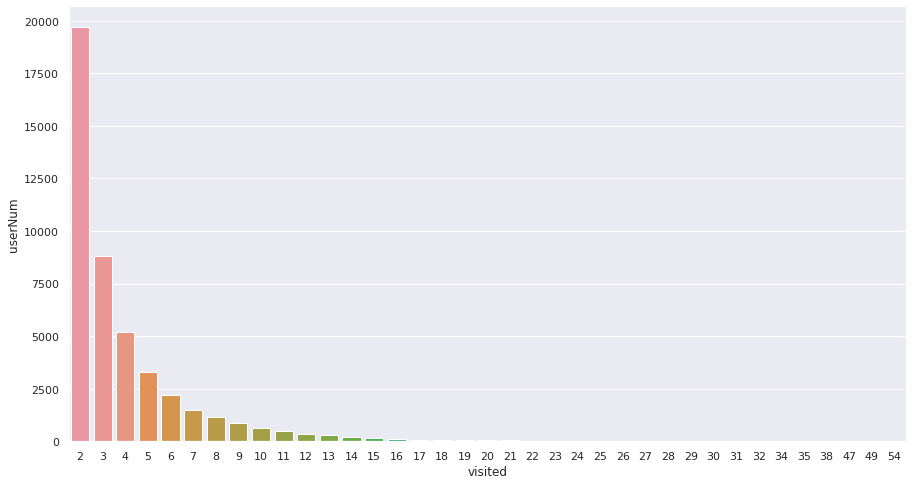

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
visited_df = user_visited['visited'].value_counts().reset_index()
visited_df.columns = ['visited', 'userNum']
ax = sns.barplot(x="visited", y="userNum", data=visited_df)

In [9]:
review = review[review['userHash'].isin(user_visited.userHash)]
review = review[['userHash', 'placeID', 'timestamp']].sort_values(['userHash', 'timestamp']).reset_index(drop=True)

In [10]:
review

,userHash,placeID,timestamp
0,5b61c7658f8242cb2a1b1028,스시언경기성남시분당구정자일로135푸르지오시티3차D동116호,1.641514e+09
1,5b61c7658f8242cb2a1b1028,"리베르떼서울강남구논현로26길551층-리베르떼,2층-브띠끄",1.643501e+09
2,5b61c7658f8242cb2a1b1028,마키노차야판교점경기성남시분당구판교역로145알파돔시티2동라스트리트B1층,1.645229e+09
3,5b61c7658f8242cb2a1b1028,양산도분당정자점경기성남시분당구정자일로1201층105호,1.646611e+09
4,5b61c7658f8242cb2a1b1028,데이빗앤룰스경기성남시분당구서판교로44번길17-7사근재,1.648166e+09
...,...,...,...
179409,627a58c17bac195bb363959f,맛깔1987서울마포구동교로212-9,1.652227e+09
179410,627dea2dcc195b28cef623a2,교대갈비집서울서초구반포대로28길91대진빌딩2층,1.652141e+09
179411,627dea2dcc195b28cef623a2,하누에뜰서울중구동호로207하누에뜰,1.652400e+09
179412,627e1585d103aee168f75f72,교대갈비집서울서초구반포대로28길91대진빌딩2층,1.651968e+09


In [11]:
userNum = review.userHash.nunique()
placeNum = review.placeID.nunique()
reviewNum = len(review.groupby(['userHash','placeID']))
print(userNum, placeNum)
print('Sparse Ratio:', 1 - reviewNum / (userNum * placeNum))

45381 9279
Sparse Ratio: 0.9995739298662875


In [12]:
class MapLoader:
    def __init__(self, data_dir):
        with open(data_dir+"/food.pickle", "rb")  as f:
            place = pickle.load(f)
            
        place['placeID'] = place.apply(lambda x : x['placeName'] + x['placeAddress'], axis = 1)
        place['placeID'] = place['placeID'].apply(lambda x : x.replace(" ", ""))
        place['map'] = place[['longitude','latitude']].apply(lambda x: tuple(x.values),axis=1)
        self.place = place[~place.placeType.str.contains('성급')].reset_index().copy()
        self.R = 6373.0
        self.r = 1
    
    
    def distance_from_coord(self, o_coord, d_coord):
        x1, y1 = radians(o_coord[0]), radians(o_coord[1])
        x2, y2 = radians(d_coord[0]), radians(d_coord[1])
        dlon = x2 - x1
        dlat = y2 - y1
        a = sin(dlat / 2)**2 + cos(y1) * cos(y2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a))    
        return self.R * c


    def filtermap(self, coor):
        name=[]
        for idx,plc in enumerate(self.place['map']):
            if self.distance_from_coord(coor,plc)<=self.r:
                name.append(self.place.loc[idx]['placeID'])
        return name

In [13]:
class CossimRecommender:
    def __init__(self, data_dir):
        self.id2place, self.place2id, self.place_emb = create_embedding_file(data_dir)
        self.cossim = cosine_similarity(np.array(self.place_emb))
        self.map_loader = MapLoader(data_dir=data_dir)
        
    
    def get_nearest_cossim(self, nearest_list, place_id, k=5):
        print(self.id2place[place_id])
        nearest_ids = [self.place2id[n] for n in nearest_list]
        nearest_cossim = self.cossim[place_id, nearest_ids[:]]
        topk = np.argsort(nearest_cossim)[::-1][1:k+1]
        return [self.id2place[nearest_ids[i]] for i in topk]
    
    
    def recommend(self, coor, place_id):
        nearest_list = self.map_loader.filtermap(coor)
        topk = self.get_nearest_cossim(nearest_list, place_id)
        return topk

In [14]:
def create_embedding_file(data_dir) :
    with open(data_dir + 'metapath_embeddings', 'r') as f:
        id2word_len, emb_dimension = f.readline().split()
        id2word = {}
        word2id = {}
        embeddings = []
        idx = 0
        while True :
            z = f.readline()
            if not z :
                break
            z = z.split()
            word = z[0]
            embedding = list(map(float, z[1:]))
            embeddings.append(embedding)
            id2word[idx] = word
            word2id[word] = idx
            idx += 1
    return id2word, word2id, embeddings

In [15]:
model = CossimRecommender('/opt/ml/final-project-level3-recsys-02/data/')